# Classificador de Abalones

Esse classificador foi desenvolvido por [cauetron](https://github.com/cauetron) como atividade da disciplina de Aprendizado de Máquina ministrada pelo professor Aydano Machado. Mais informações podem ser encontradas [aqui](https://github.com/aydanomachado/mlclass/tree/master/03_Validation)

In [97]:
import requests

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers


## Explorando dataset Abalone

Inicialmente vamos importar o dataset e separar as features das labels

In [98]:
data = pd.read_csv('https://raw.githubusercontent.com/aydanomachado/mlclass/master/03_Validation/abalone_dataset.csv')

feature_cols = ["sex", "length", "diameter", "height", "whole_weight",
                "shucked_weight", "viscera_weight", "shell_weight"]

X = data[feature_cols]
y = data.type

data

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,type
0,M,0.535,0.420,0.150,0.6995,0.2575,0.1530,0.2400,3
1,I,0.510,0.380,0.115,0.5155,0.2150,0.1135,0.1660,1
2,I,0.185,0.130,0.045,0.0290,0.0120,0.0075,0.0095,1
3,M,0.550,0.450,0.170,0.8100,0.3170,0.1570,0.2200,3
4,I,0.535,0.415,0.150,0.5765,0.3595,0.1350,0.2250,1
...,...,...,...,...,...,...,...,...,...
3127,F,0.545,0.405,0.175,0.9800,0.2585,0.2070,0.3800,3
3128,M,0.655,0.525,0.185,1.2590,0.4870,0.2215,0.4450,3
3129,I,0.450,0.340,0.120,0.4925,0.2410,0.1075,0.1200,1
3130,F,0.520,0.410,0.155,0.7270,0.2910,0.1835,0.2350,3


Motivado pelo exercício anterior, vamos observar a quantidade de NaN no dataset

In [99]:
data.isna().sum()

sex               0
length            0
diameter          0
height            0
whole_weight      0
shucked_weight    0
viscera_weight    0
shell_weight      0
type              0
dtype: int64

Podemos observar logo de cara que a variável sex é uma variável categórica que pertence ao conjunto [M, F, I]
Como não existe uma hierarquia entre essas categorias, vamos utilizar one-hot encoding

In [100]:
X = pd.get_dummies(data=X, columns=['sex'])
X

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_F,sex_I,sex_M
0,0.535,0.420,0.150,0.6995,0.2575,0.1530,0.2400,0,0,1
1,0.510,0.380,0.115,0.5155,0.2150,0.1135,0.1660,0,1,0
2,0.185,0.130,0.045,0.0290,0.0120,0.0075,0.0095,0,1,0
3,0.550,0.450,0.170,0.8100,0.3170,0.1570,0.2200,0,0,1
4,0.535,0.415,0.150,0.5765,0.3595,0.1350,0.2250,0,1,0
...,...,...,...,...,...,...,...,...,...,...
3127,0.545,0.405,0.175,0.9800,0.2585,0.2070,0.3800,1,0,0
3128,0.655,0.525,0.185,1.2590,0.4870,0.2215,0.4450,0,0,1
3129,0.450,0.340,0.120,0.4925,0.2410,0.1075,0.1200,0,1,0
3130,0.520,0.410,0.155,0.7270,0.2910,0.1835,0.2350,1,0,0


Agora vamos plotar o histograma do dataset para poder visualizar melhor a distribuição das features e das labels

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8394485710>,
      dtype=object)

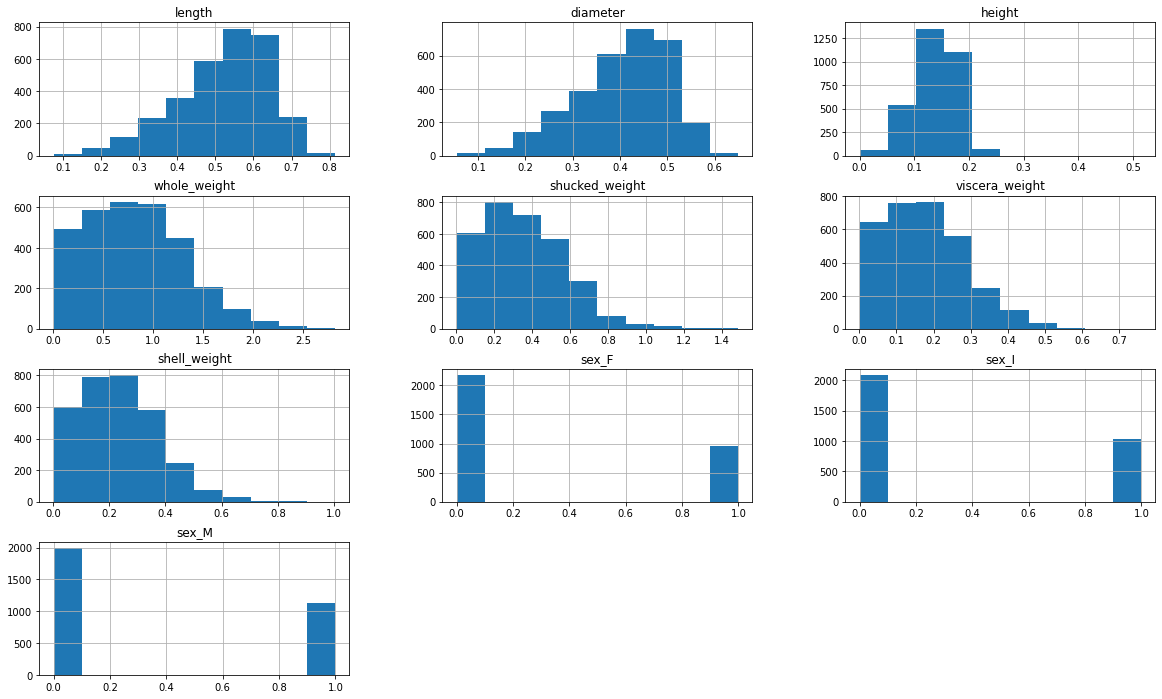

In [101]:
X.hist(figsize=(20, 12))

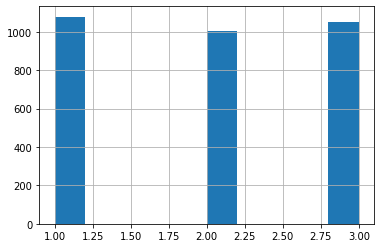

In [102]:
y.hist()

Podemos observar que o dataset está bem balanceado, antes de seguir adiante, vamos subtrair 1 de cada classe para deixar esse valor entre [0,2]

In [103]:
y = y - 1

In [104]:
# data.boxplot(figsize=(20, 12))

## Dividindo a base em treinamento, validação e teste

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42)

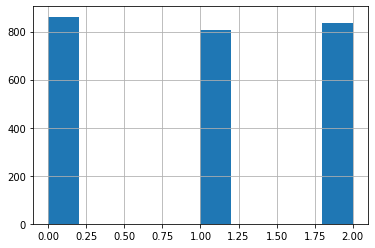

In [28]:
y_train.hist()

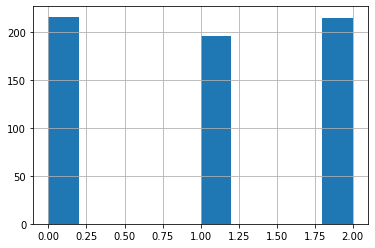

In [30]:
y_test.hist()

Vamos utilizar a validação cruzada K-fold para validar nosso modelo.

In [32]:
def k_fold_validation(model, train_data, train_targets, epochs, batch_size, k):
  num_val_samples = len(train_data) // k
  all_acc_histories = []
  all_loss_histories = []

  for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
         axis=0
    )

    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
         axis=0
    )

    history = model.fit(partial_train_data,
                        partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0)
    
    acc_history = history.history["val_accuracy"]
    all_acc_histories.append(acc_history)

    loss_history = history.history["val_loss"]
    all_loss_histories.append(loss_history)



    acc_training = history.history["accuracy"][-1]
    loss_training = history.history["loss"][-1]
    
    print(f"Accuracy Training: {acc_training} / Validation: {acc_history[-1]}")
    print(f"Loss Training: {loss_training} / Validation: {loss_history[-1]}")
    

  return {"val_accuracy": all_acc_histories, "val_loss": all_loss_histories}

## Em busca de um baseline

Vamos criar alguns dicionarios para facilitar a organização e acesso a os modelos e seus repectivos scores / history objects.

In [19]:
models = {}
histories = {}
scores = {}

Seguindo o princípio da Navalha de Ockham, vamos começar pelo mais simples: um modelo de regressão logística.

In [ ]:
models["baseline"] = keras.Sequential([
    layers.Dense(3, activation="softmax")
])
models["baseline"].compile(optimizer="rmsprop",
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

histories["baseline"] = k_fold_validation(models["baseline"],
                                          X_train, y_train, 
                                          epochs=100,
                                          batch_size=128,
                                          k=5)

scores["baseline"] = models["baseline"].evaluate(X_test, y_test)
scores["baseline"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4
20/20 [==============================] - 0s 2ms/step - loss: 0.8127 - accuracy: 0.6268


[0.8127433657646179, 0.6267942786216736]

Assim, o nosso baseline tem uma acurácia de **62.7%.** Vamos visualizar o gráfico da validation loss e da validation accuracy.





In [20]:
def plot_avg_acc(history_model, epochs):
  avg_acc_history = [
      np.mean([x[i] for x in history_model["val_accuracy"]]) for i in range(epochs)
  ]
  plt.plot(range(1, len(avg_acc_history) + 1), avg_acc_history)
  plt.xlabel("Epochs")
  plt.ylabel("Validation accuracy")
  plt.show()

In [21]:
def plot_avg_loss(history_model, epochs):
  avg_loss_history = [
      np.mean([x[i] for x in history_model["val_loss"]]) for i in range(epochs)
  ]
  plt.plot(range(1, len(avg_loss_history) + 1), avg_loss_history)
  plt.xlabel("Epochs")
  plt.ylabel("Validation loss")
  plt.show()

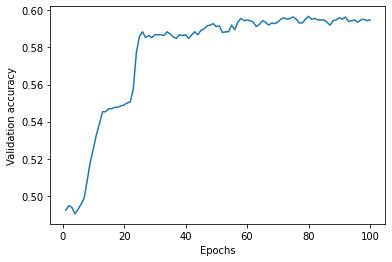

In [ ]:
plot_avg_acc(histories["baseline"], epochs=100)

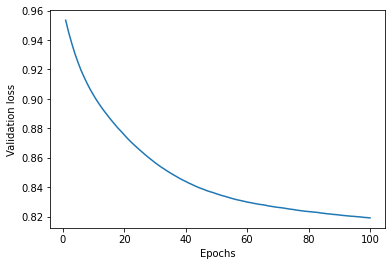

In [ ]:
plot_avg_loss(histories["baseline"], epochs=100)

Um ponto interessante é que o modelo acima conseguiu fitar mas não parece ser capaz de overfitting. Dessa maneira, nossa estratégia agora vai ser aumentar o poder representacional do modelo até atingir o overfitting e só aí começar a trabalhar na generelização

## Explorando um modelo de rede neural simples

In [ ]:
models["mlp_v1"] = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v1"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v1"] = k_fold_validation(models["mlp_v1"],
                                        X_train, y_train, 
                                        epochs=100,
                                        batch_size=128,
                                        k=5)

scores["mlp_v1"] = models["mlp_v1"].evaluate(X_test, y_test)
scores["mlp_v1"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4
20/20 [==============================] - 0s 1ms/step - loss: 0.7437 - accuracy: 0.6539


[0.7437419891357422, 0.6539074778556824]

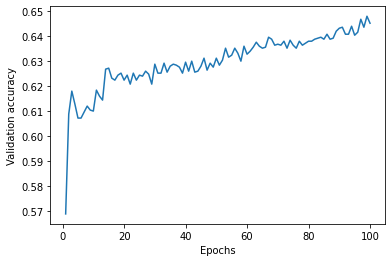

In [ ]:
plot_avg_acc(histories["mlp_v1"], epochs=100)

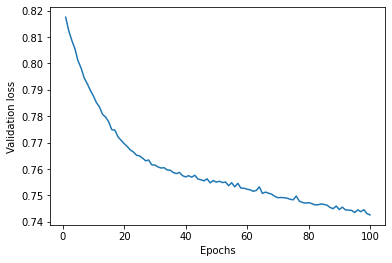

In [ ]:
plot_avg_loss(histories["mlp_v1"], epochs=100)

O modelo conseguiu uma acurácia de 65.4% o que é maior do que a do baseline, mas não foi capaz de overfitting, então vamos aumentar a capacidade representacional do nosso modelo

## Em busca do overfitting perdido

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


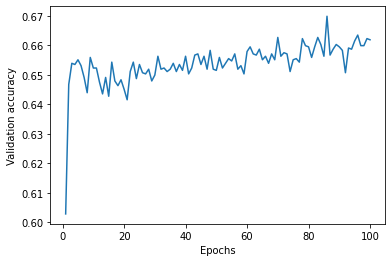

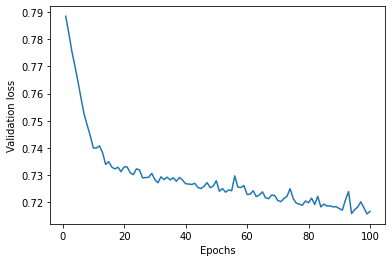

20/20 [==============================] - 0s 2ms/step - loss: 0.7277 - accuracy: 0.6667


[0.7277271747589111, 0.6666666865348816]

In [ ]:
models["mlp_v2"] = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v2"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v2"] = k_fold_validation(models["mlp_v2"],
                                             X_train, y_train, 
                                             epochs=100,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v2"], epochs=100)
plot_avg_loss(histories["mlp_v2"], epochs=100)

scores["mlp_v2"] = models["mlp_v2"].evaluate(X_test, y_test)
scores["mlp_v2"]

A acurácia aumentou para 66.66% mas ainda não atingimos o overfitting, vamos continuar com essa busca aumentando o nome de epocas

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


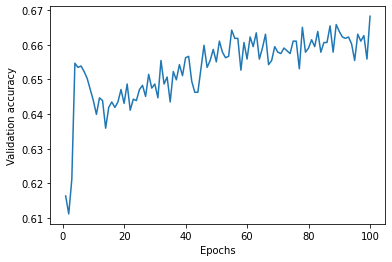

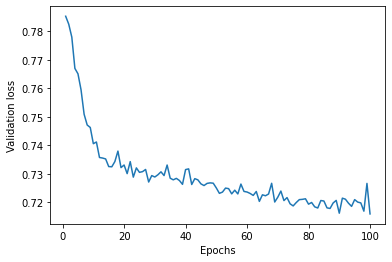

20/20 [==============================] - 0s 2ms/step - loss: 0.7322 - accuracy: 0.6778


[0.7322306632995605, 0.6778309345245361]

In [ ]:
models["mlp_v2_2"] = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v2_2"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v2_2"] = k_fold_validation(models["mlp_v2_2"],
                                             X_train, y_train, 
                                             epochs=200,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v2_2"], epochs=100)
plot_avg_loss(histories["mlp_v2_2"], epochs=100)

scores["mlp_v2_2"] = models["mlp_v2_2"].evaluate(X_test, y_test)
scores["mlp_v2_2"]

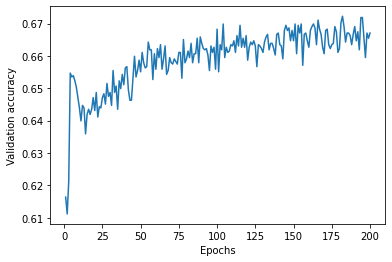

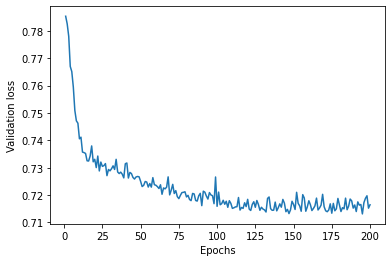

In [ ]:
plot_avg_acc(histories["mlp_v2_2"], epochs=200)
plot_avg_loss(histories["mlp_v2_2"], epochs=200)

Uma pequena correção na plotagem dos gáficos passados. 

Além disso, conseguimos uma acurácia de **67.7%**, e ainda não temos um overfitting claro. Vamos continuar explorando outras configurações

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


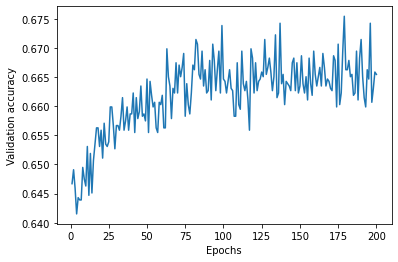

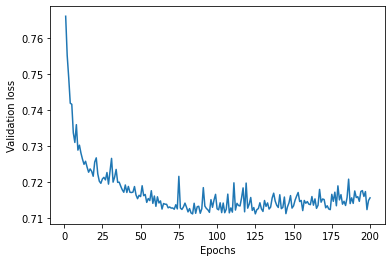

20/20 [==============================] - 0s 1ms/step - loss: 0.7342 - accuracy: 0.6762


[0.7341883182525635, 0.6762360334396362]

In [ ]:
epochs=200

models["mlp_v2_3"] = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v2_3"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v2_3"] = k_fold_validation(models["mlp_v2_3"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v2_3"], epochs=epochs)
plot_avg_loss(histories["mlp_v2_3"], epochs=epochs)

scores["mlp_v2_3"] = models["mlp_v2_3"].evaluate(X_test, y_test)
scores["mlp_v2_3"]

Identificamos um possível ponto de overfitting, vamos trabalhar com 200 épocas e testar em modelos mais potentes

## Investigando outras configurações

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


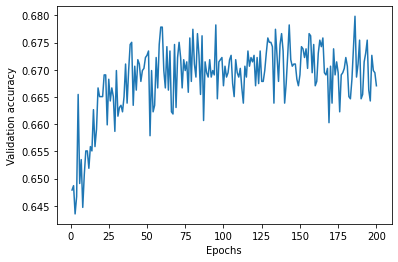

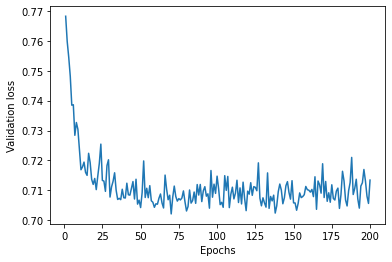

20/20 [==============================] - 0s 2ms/step - loss: 0.7550 - accuracy: 0.6443


[0.7549733519554138, 0.6443381309509277]

In [ ]:
epochs = 200

models["mlp_v3"] = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v3"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v3"] = k_fold_validation(models["mlp_v3"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v3"], epochs=epochs)
plot_avg_loss(histories["mlp_v3"], epochs=epochs)

scores["mlp_v3"] = models["mlp_v3"].evaluate(X_test, y_test)
scores["mlp_v3"]

Ainda não atingimos o overfitting, mas vemos que estamos aumentando o ruído.Vamos continuar explorando mais configurações

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


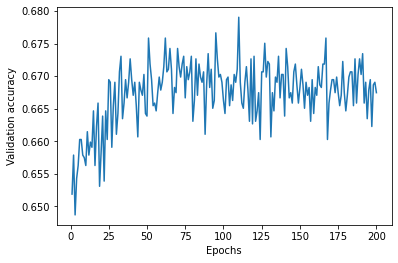

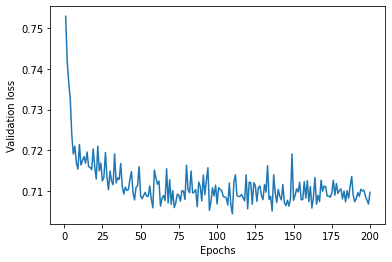

20/20 [==============================] - 0s 2ms/step - loss: 0.7389 - accuracy: 0.6651


[0.7389159798622131, 0.6650717854499817]

In [ ]:
epochs=200

models["mlp_v4"] = keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v4"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v4"] = k_fold_validation(models["mlp_v4"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v4"], epochs=epochs)
plot_avg_loss(histories["mlp_v4"], epochs=epochs)

scores["mlp_v4"] = models["mlp_v4"].evaluate(X_test, y_test)
scores["mlp_v4"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


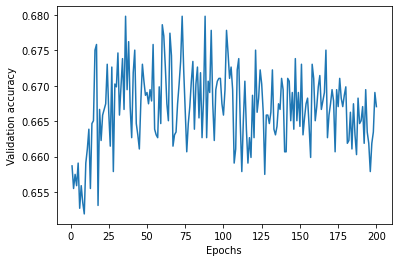

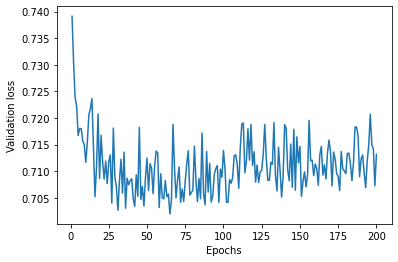

20/20 [==============================] - 0s 1ms/step - loss: 0.7727 - accuracy: 0.6364


[0.7727147936820984, 0.6363636255264282]

In [ ]:
epochs=200

models["mlp_v5"] = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v5"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v5"] = k_fold_validation(models["mlp_v5"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v5"], epochs=epochs)
plot_avg_loss(histories["mlp_v5"], epochs=epochs)

scores["mlp_v5"] = models["mlp_v5"].evaluate(X_test, y_test)
scores["mlp_v5"]

Parece que achamos o overfitting, vamos aumentar ainda mais a capacidade desse modelo

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


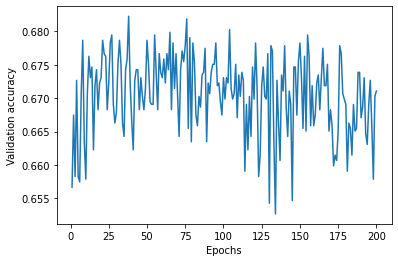

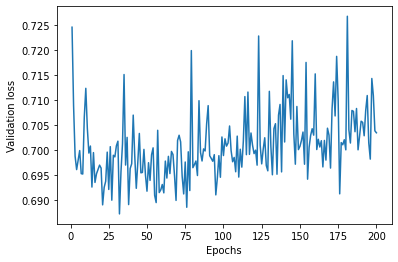

20/20 [==============================] - 0s 2ms/step - loss: 0.8099 - accuracy: 0.6507


[0.8099247217178345, 0.6507176756858826]

In [ ]:
epochs=200

models["mlp_v6"] = keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v6"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v6"] = k_fold_validation(models["mlp_v6"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v6"], epochs=epochs)
plot_avg_loss(histories["mlp_v6"], epochs=epochs)

scores["mlp_v6"] = models["mlp_v6"].evaluate(X_test, y_test)
scores["mlp_v6"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


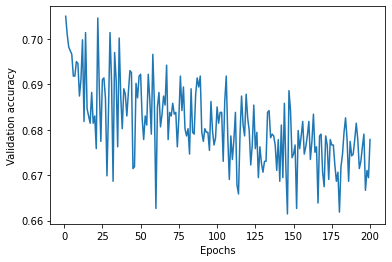

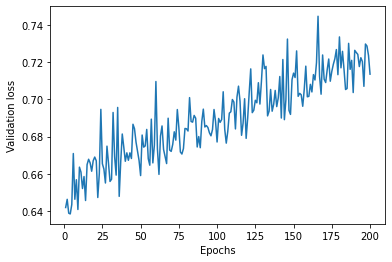

20/20 [==============================] - 0s 2ms/step - loss: 1.2189 - accuracy: 0.6156


[1.2188936471939087, 0.6156299710273743]

In [ ]:
epochs=200

models["mlp_v7"] = keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v7"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v7"] = k_fold_validation(models["mlp_v7"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v7"], epochs=epochs)
plot_avg_loss(histories["mlp_v7"], epochs=epochs)

scores["mlp_v7"] = models["mlp_v7"].evaluate(X_test, y_test)
scores["mlp_v7"]

Montamos uma configuração bem exagerada. O lado bom é que já sabemos onde não explorar

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


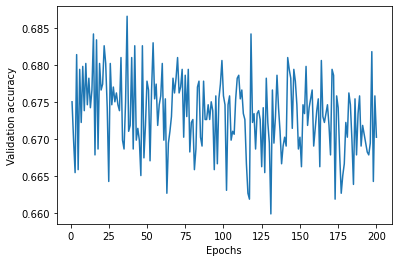

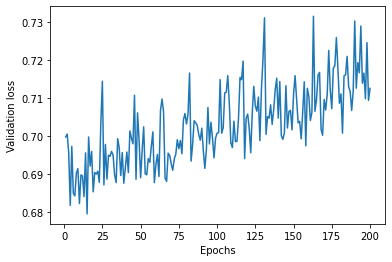

20/20 [==============================] - 0s 1ms/step - loss: 0.8555 - accuracy: 0.6411


[0.8555079698562622, 0.6411483287811279]

In [ ]:
epochs=200

models["mlp_v8"] = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v8"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v8"] = k_fold_validation(models["mlp_v8"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v8"], epochs=epochs)
plot_avg_loss(histories["mlp_v8"], epochs=epochs)

scores["mlp_v8"] = models["mlp_v8"].evaluate(X_test, y_test)
scores["mlp_v8"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


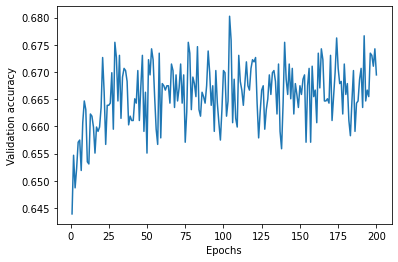

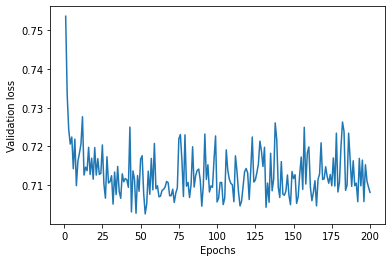

20/20 [==============================] - 0s 2ms/step - loss: 0.7639 - accuracy: 0.6603


[0.7639116644859314, 0.660287082195282]

In [ ]:
epochs=200

models["mlp_v9"] = keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v9"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v9"] = k_fold_validation(models["mlp_v9"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v9"], epochs=epochs)
plot_avg_loss(histories["mlp_v9"], epochs=epochs)

scores["mlp_v9"] = models["mlp_v9"].evaluate(X_test, y_test)
scores["mlp_v9"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


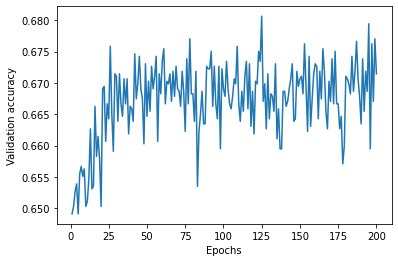

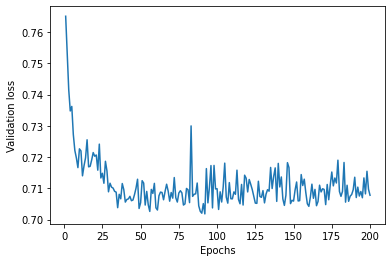

20/20 [==============================] - 0s 1ms/step - loss: 0.7553 - accuracy: 0.6523


[0.7553481459617615, 0.6523125767707825]

In [ ]:
epochs=200

models["mlp_v10"] = keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v10"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v10"] = k_fold_validation(models["mlp_v10"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v10"], epochs=epochs)
plot_avg_loss(histories["mlp_v10"], epochs=epochs)

scores["mlp_v10"] = models["mlp_v10"].evaluate(X_test, y_test)
scores["mlp_v10"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


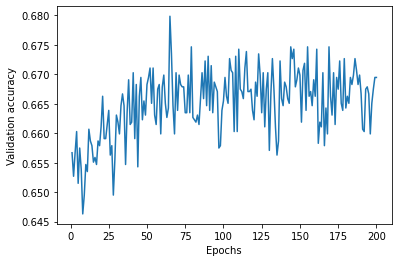

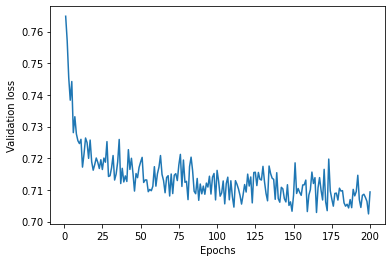

20/20 [==============================] - 0s 1ms/step - loss: 0.7414 - accuracy: 0.6603


[0.7413817048072815, 0.660287082195282]

In [ ]:
epochs=200

models["mlp_v11"] = keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v11"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v11"] = k_fold_validation(models["mlp_v11"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v11"], epochs=epochs)
plot_avg_loss(histories["mlp_v11"], epochs=epochs)

scores["mlp_v11"] = models["mlp_v11"].evaluate(X_test, y_test)
scores["mlp_v11"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


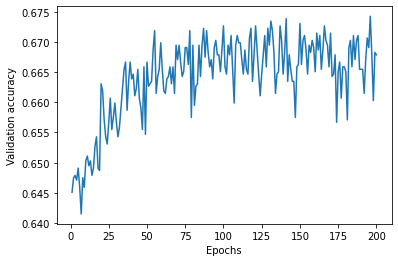

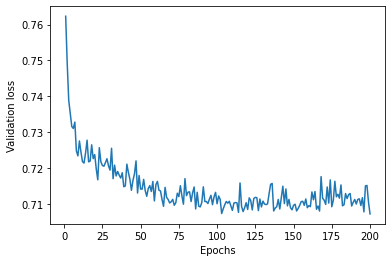

20/20 [==============================] - 0s 2ms/step - loss: 0.7276 - accuracy: 0.6667


[0.7275667786598206, 0.6666666865348816]

In [ ]:
epochs=200

models["mlp_v12"] = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v12"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v12"] = k_fold_validation(models["mlp_v12"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v12"], epochs=epochs)
plot_avg_loss(histories["mlp_v12"], epochs=epochs)

scores["mlp_v12"] = models["mlp_v12"].evaluate(X_test, y_test)
scores["mlp_v12"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


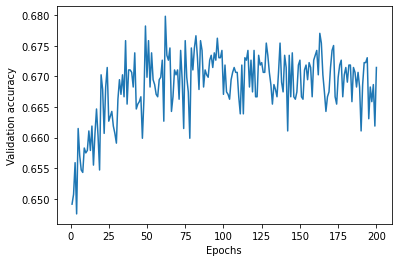

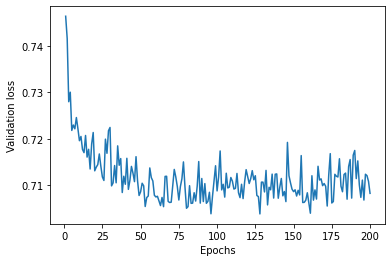

20/20 [==============================] - 0s 1ms/step - loss: 0.7408 - accuracy: 0.6603


[0.7408145070075989, 0.660287082195282]

In [ ]:
epochs=200

models["mlp_v13"] = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v13"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v13"] = k_fold_validation(models["mlp_v13"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v13"], epochs=epochs)
plot_avg_loss(histories["mlp_v13"], epochs=epochs)

scores["mlp_v13"] = models["mlp_v13"].evaluate(X_test, y_test)
scores["mlp_v13"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


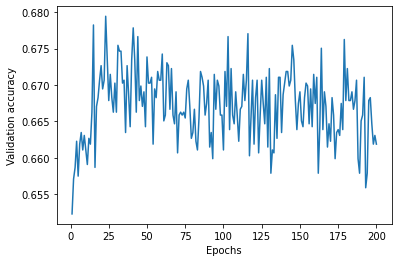

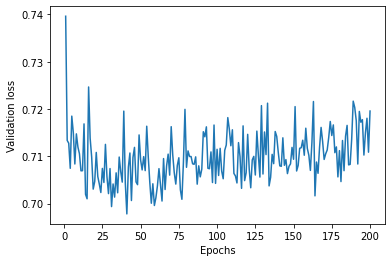

20/20 [==============================] - 0s 1ms/step - loss: 0.7935 - accuracy: 0.6539


[0.7934848666191101, 0.6539074778556824]

In [ ]:
epochs=200

models["mlp_v14"] = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v14"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v14"] = k_fold_validation(models["mlp_v14"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v14"], epochs=epochs)
plot_avg_loss(histories["mlp_v14"], epochs=epochs)

scores["mlp_v14"] = models["mlp_v14"].evaluate(X_test, y_test)
scores["mlp_v14"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


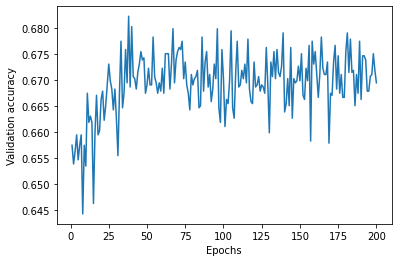

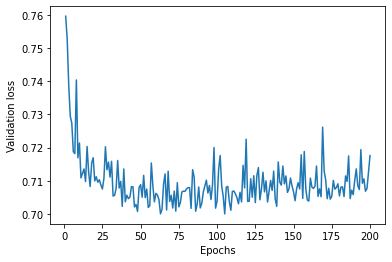

20/20 [==============================] - 0s 2ms/step - loss: 0.7394 - accuracy: 0.6587


[0.7394436597824097, 0.6586921811103821]

In [ ]:
epochs=200

models["mlp_v15"] = keras.Sequential([
    layers.Dense(24, activation="relu"),
    layers.Dense(24, activation="relu"),
    layers.Dense(24, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v15"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v15"] = k_fold_validation(models["mlp_v15"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v15"], epochs=epochs)
plot_avg_loss(histories["mlp_v15"], epochs=epochs)

scores["mlp_v15"] = models["mlp_v15"].evaluate(X_test, y_test)
scores["mlp_v15"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


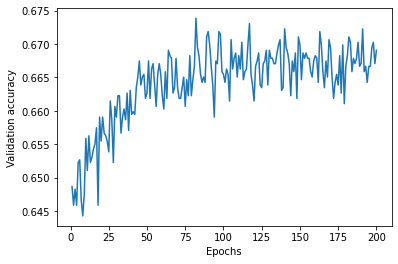

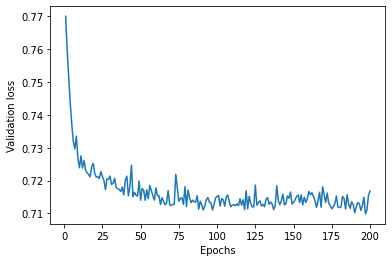

20/20 [==============================] - 0s 2ms/step - loss: 0.7343 - accuracy: 0.6667


[0.734268844127655, 0.6666666865348816]

In [ ]:
epochs=200

models["mlp_v16"] = keras.Sequential([
    layers.Dense(24, activation="relu"),
    layers.Dense(24, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v16"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v16"] = k_fold_validation(models["mlp_v16"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v16"], epochs=epochs)
plot_avg_loss(histories["mlp_v16"], epochs=epochs)

scores["mlp_v16"] = models["mlp_v16"].evaluate(X_test, y_test)
scores["mlp_v16"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


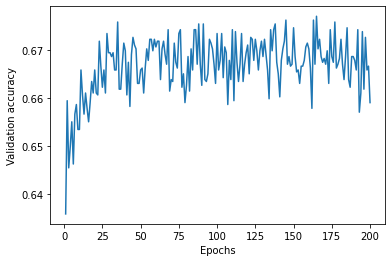

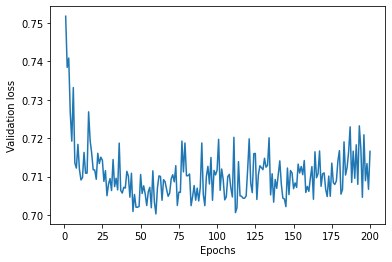

20/20 [==============================] - 0s 1ms/step - loss: 0.7595 - accuracy: 0.6507


[0.759488046169281, 0.6507176756858826]

In [ ]:
epochs=200

models["mlp_v17"] = keras.Sequential([
    layers.Dense(28, activation="relu"),
    layers.Dense(28, activation="relu"),
    layers.Dense(28, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v17"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v17"] = k_fold_validation(models["mlp_v17"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v17"], epochs=epochs)
plot_avg_loss(histories["mlp_v17"], epochs=epochs)

scores["mlp_v17"] = models["mlp_v17"].evaluate(X_test, y_test)
scores["mlp_v17"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


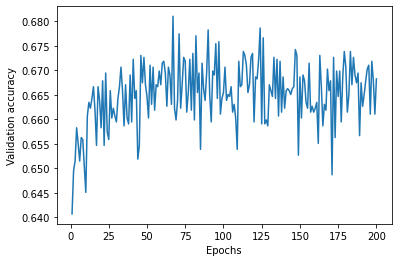

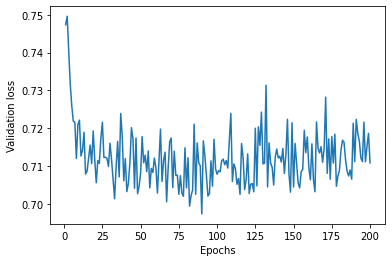

20/20 [==============================] - 0s 1ms/step - loss: 0.7880 - accuracy: 0.6555


[0.7880237102508545, 0.6555023789405823]

In [ ]:
epochs=200

models["mlp_v18"] = keras.Sequential([
    layers.Dense(28, activation="relu"),
    layers.Dense(28, activation="relu"),
    layers.Dense(28, activation="relu"),
    layers.Dense(28, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v18"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v18"] = k_fold_validation(models["mlp_v18"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v18"], epochs=epochs)
plot_avg_loss(histories["mlp_v18"], epochs=epochs)

scores["mlp_v18"] = models["mlp_v18"].evaluate(X_test, y_test)
scores["mlp_v18"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


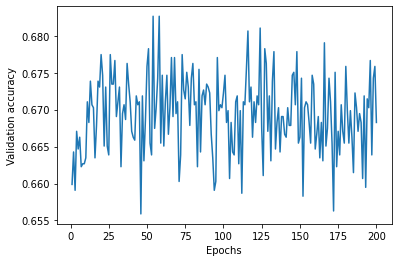

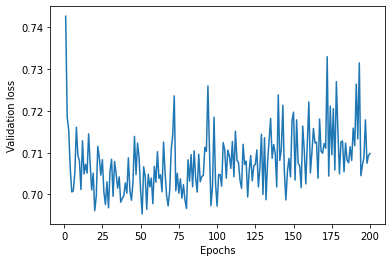

20/20 [==============================] - 0s 2ms/step - loss: 0.7926 - accuracy: 0.6364


[0.7925974726676941, 0.6363636255264282]

In [ ]:
epochs=200

models["mlp_v19"] = keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(28, activation="relu"),
    layers.Dense(28, activation="relu"),
    layers.Dense(24, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v19"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v19"] = k_fold_validation(models["mlp_v19"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v19"], epochs=epochs)
plot_avg_loss(histories["mlp_v19"], epochs=epochs)

scores["mlp_v19"] = models["mlp_v19"].evaluate(X_test, y_test)
scores["mlp_v19"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


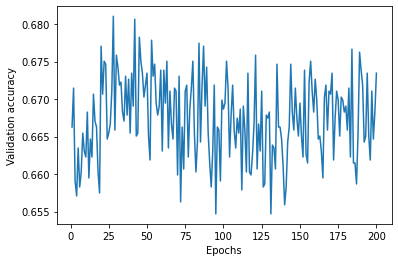

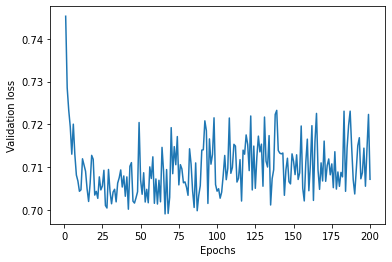

20/20 [==============================] - 0s 2ms/step - loss: 0.7795 - accuracy: 0.6571


[0.7794969081878662, 0.6570972800254822]

In [ ]:
epochs=200

models["mlp_v20"] = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(42, activation="relu"),
    layers.Dense(24, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v20"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v20"] = k_fold_validation(models["mlp_v20"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v20"], epochs=epochs)
plot_avg_loss(histories["mlp_v20"], epochs=epochs)

scores["mlp_v20"] = models["mlp_v20"].evaluate(X_test, y_test)
scores["mlp_v20"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


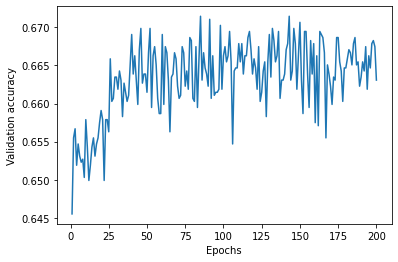

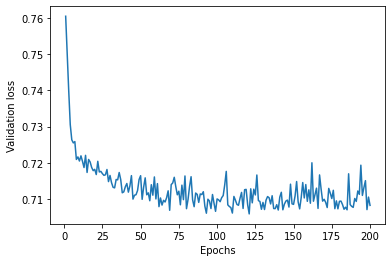

20/20 [==============================] - 0s 1ms/step - loss: 0.7353 - accuracy: 0.6683


[0.7352955341339111, 0.6682615876197815]

In [ ]:
epochs=200

models["mlp_v21"] = keras.Sequential([
    layers.Dense(27, activation="relu"),
    layers.Dense(27, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v21"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v21"] = k_fold_validation(models["mlp_v21"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v21"], epochs=epochs)
plot_avg_loss(histories["mlp_v21"], epochs=epochs)

scores["mlp_v21"] = models["mlp_v21"].evaluate(X_test, y_test)
scores["mlp_v21"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


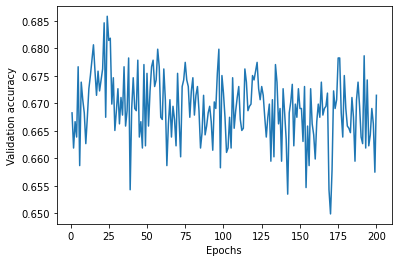

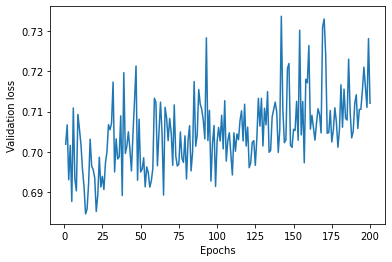

20/20 [==============================] - 0s 2ms/step - loss: 0.8494 - accuracy: 0.6396


[0.8493953943252563, 0.639553427696228]

In [ ]:
epochs=200

models["mlp_v22"] = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dense(42, activation="relu"),
    layers.Dense(21, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v22"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v22"] = k_fold_validation(models["mlp_v22"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v22"], epochs=epochs)
plot_avg_loss(histories["mlp_v22"], epochs=epochs)

scores["mlp_v22"] = models["mlp_v22"].evaluate(X_test, y_test)
scores["mlp_v22"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


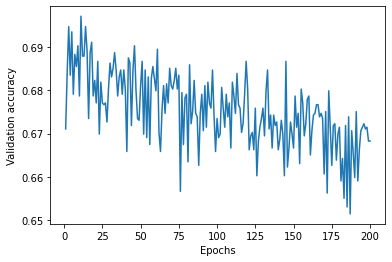

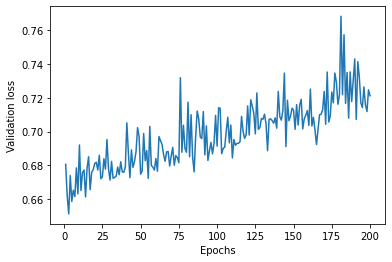

20/20 [==============================] - 0s 2ms/step - loss: 1.0635 - accuracy: 0.6220


[1.0635179281234741, 0.6220095753669739]

In [ ]:
epochs=200

models["mlp_v23"] = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(21, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v23"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v23"] = k_fold_validation(models["mlp_v23"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v23"], epochs=epochs)
plot_avg_loss(histories["mlp_v23"], epochs=epochs)

scores["mlp_v23"] = models["mlp_v23"].evaluate(X_test, y_test)
scores["mlp_v23"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


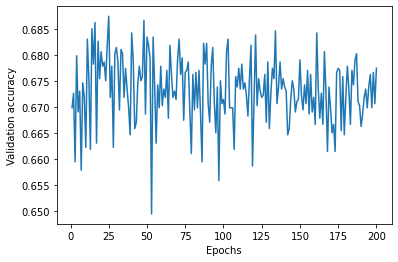

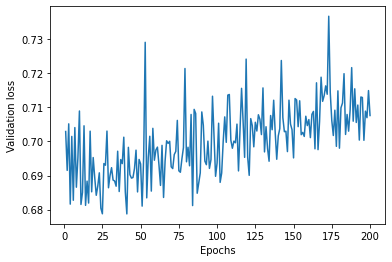

20/20 [==============================] - 0s 2ms/step - loss: 0.8881 - accuracy: 0.6364


[0.8881327509880066, 0.6363636255264282]

In [ ]:
epochs=200

models["mlp_v24"] = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v24"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v24"] = k_fold_validation(models["mlp_v24"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v24"], epochs=epochs)
plot_avg_loss(histories["mlp_v24"], epochs=epochs)

scores["mlp_v24"] = models["mlp_v24"].evaluate(X_test, y_test)
scores["mlp_v24"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


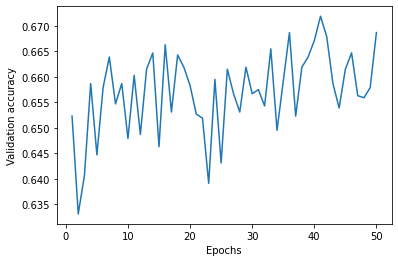

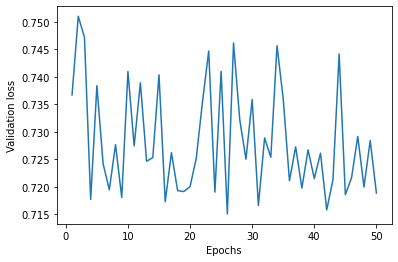

20/20 [==============================] - 0s 1ms/step - loss: 0.7499 - accuracy: 0.6651


[0.7498882412910461, 0.6650717854499817]

In [ ]:
epochs=50

models["mlp_v25"] = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(21, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v25"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v25"] = k_fold_validation(models["mlp_v25"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v25"], epochs=epochs)
plot_avg_loss(histories["mlp_v25"], epochs=epochs)

scores["mlp_v25"] = models["mlp_v25"].evaluate(X_test, y_test)
scores["mlp_v25"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


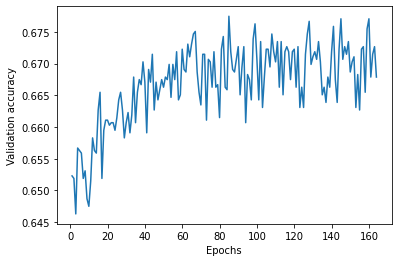

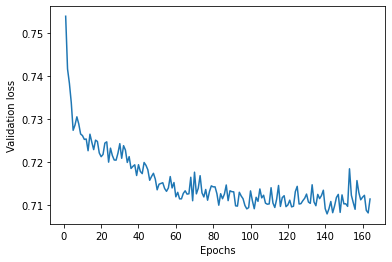

20/20 [==============================] - 0s 1ms/step - loss: 0.7328 - accuracy: 0.6778


[0.7328194975852966, 0.6778309345245361]

In [ ]:
epochs=164

models["mlp_v26"] = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_v26"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v26"] = k_fold_validation(models["mlp_v26"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v26"], epochs=epochs)
plot_avg_loss(histories["mlp_v26"], epochs=epochs)

scores["mlp_v26"] = models["mlp_v26"].evaluate(X_test, y_test)
scores["mlp_v26"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


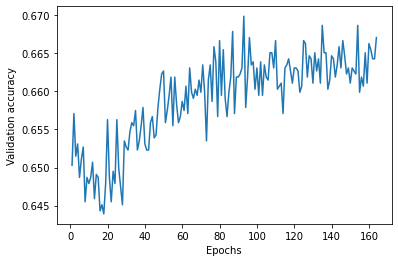

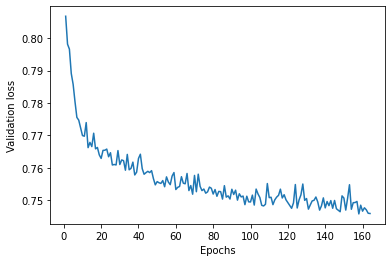

20/20 [==============================] - 0s 2ms/step - loss: 0.7507 - accuracy: 0.6651


[0.7506508827209473, 0.6650717854499817]

In [ ]:
epochs=164

models["mlp_v27"] = keras.Sequential([
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v27"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v27"] = k_fold_validation(models["mlp_v27"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v27"], epochs=epochs)
plot_avg_loss(histories["mlp_v27"], epochs=epochs)

scores["mlp_v27"] = models["mlp_v27"].evaluate(X_test, y_test)
scores["mlp_v27"]

In [ ]:
epochs=200

models["mlp_v28"] = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v28"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

models["mlp_v28"].fit(X_train, y_train, 
                      epochs=epochs,
                      batch_size=128)  
                                             

scores["mlp_v28"] = models["mlp_v28"].evaluate(X_test, y_test)
scores["mlp_v28"]

Epoch 1/200
20/20 [==============================] - 1s 2ms/step - loss: 1.0716 - accuracy: 0.4096
Epoch 2/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0200 - accuracy: 0.5058
Epoch 3/200
20/20 [==============================] - 0s 2ms/step - loss: 0.9769 - accuracy: 0.5194
Epoch 4/200
20/20 [==============================] - 0s 2ms/step - loss: 0.9414 - accuracy: 0.5261
Epoch 5/200
20/20 [==============================] - 0s 2ms/step - loss: 0.9120 - accuracy: 0.5357
Epoch 6/200
20/20 [==============================] - 0s 2ms/step - loss: 0.8897 - accuracy: 0.5529
Epoch 7/200
20/20 [==============================] - 0s 2ms/step - loss: 0.8739 - accuracy: 0.5541
Epoch 8/200
20/20 [==============================] - 0s 2ms/step - loss: 0.8628 - accuracy: 0.5577
Epoch 9/200
20/20 [==============================] - 0s 2ms/step - loss: 0.8562 - accuracy: 0.5589
Epoch 10/200
20/20 [==============================] - 0s 2ms/step - loss: 0.8499 - accuracy: 0.5573
Epoch 11/

[0.7378532886505127, 0.660287082195282]

## Refinando os melhores modelos

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


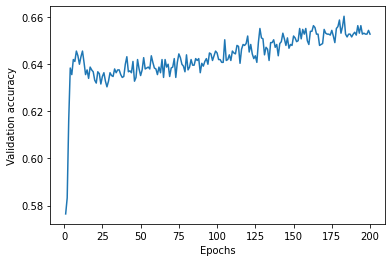

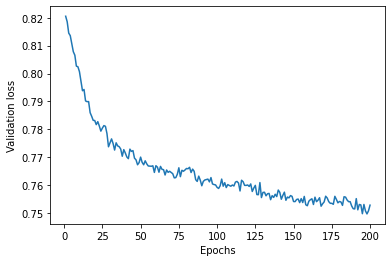

20/20 [==============================] - 0s 2ms/step - loss: 0.7595 - accuracy: 0.6619


[0.7595446109771729, 0.6618819832801819]

In [39]:
epochs=200

models["mlp_v1"] = keras.Sequential([
    layers.Dense(16, activation="relu"),
    #layers.Dropout(0.5),
    layers.Dense(16, activation="relu"),
    #layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_v1"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v1"] = k_fold_validation(models["mlp_v1"],
                                        X_train, y_train, 
                                        epochs=epochs,
                                        batch_size=128,
                                        k=5)

plot_avg_acc(histories["mlp_v1"], epochs=epochs)
plot_avg_loss(histories["mlp_v1"], epochs=epochs)

scores["mlp_v1"] = models["mlp_v1"].evaluate(X_test, y_test)
scores["mlp_v1"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


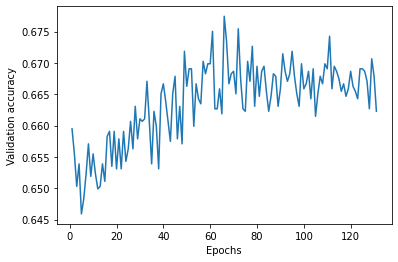

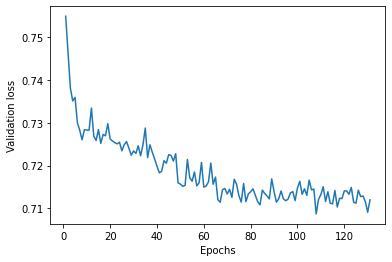

20/20 [==============================] - 0s 2ms/step - loss: 0.7310 - accuracy: 0.6746


[0.7310357093811035, 0.6746411323547363]

In [43]:
epochs=131

models["mlp_v26"] = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_v26"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v26"] = k_fold_validation(models["mlp_v26"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v26"], epochs=epochs)
plot_avg_loss(histories["mlp_v26"], epochs=epochs)

scores["mlp_v26"] = models["mlp_v26"].evaluate(X_test, y_test)
scores["mlp_v26"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


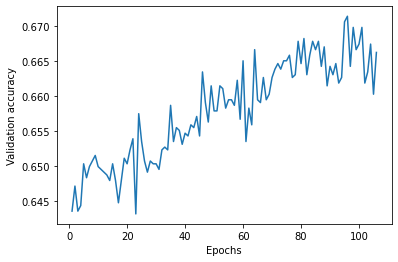

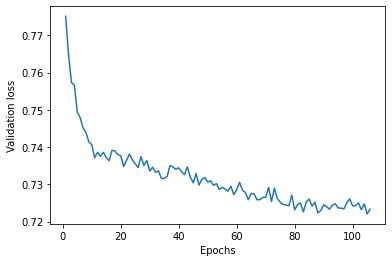

20/20 [==============================] - 0s 2ms/step - loss: 0.7284 - accuracy: 0.6762


[0.7283798456192017, 0.6762360334396362]

In [46]:
epochs=106

models["mlp_v27"] = keras.Sequential([
    layers.Dense(48, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(48, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_v27"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v27"] = k_fold_validation(models["mlp_v27"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v27"], epochs=epochs)
plot_avg_loss(histories["mlp_v27"], epochs=epochs)

scores["mlp_v27"] = models["mlp_v27"].evaluate(X_test, y_test)
scores["mlp_v27"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


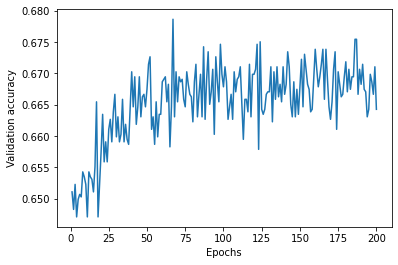

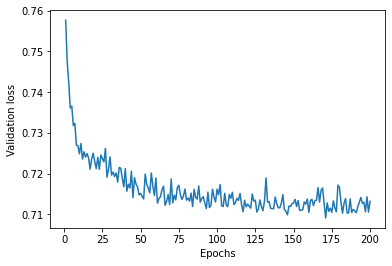

20/20 [==============================] - 0s 2ms/step - loss: 0.7324 - accuracy: 0.6715


[0.7323768138885498, 0.6714513301849365]

In [56]:
epochs=200

models["mlp_v28"] = keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v28"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v28"] = k_fold_validation(models["mlp_v28"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v28"], epochs=epochs)
plot_avg_loss(histories["mlp_v28"], epochs=epochs)

scores["mlp_v28"] = models["mlp_v28"].evaluate(X_test, y_test)
scores["mlp_v28"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


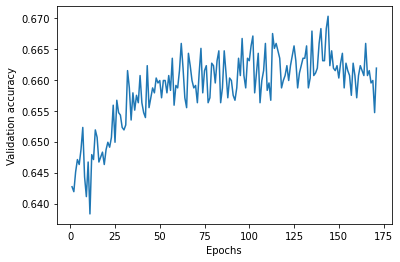

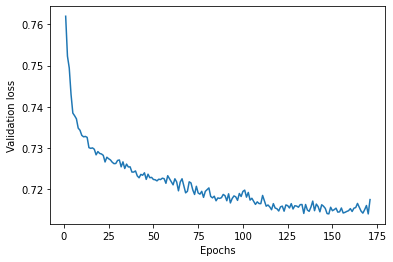

20/20 [==============================] - 0s 2ms/step - loss: 0.7360 - accuracy: 0.6635


[0.7359773516654968, 0.6634768843650818]

In [60]:
epochs=171

models["mlp_v28"] = keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_v28"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v28"] = k_fold_validation(models["mlp_v28"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v28"], epochs=epochs)
plot_avg_loss(histories["mlp_v28"], epochs=epochs)

scores["mlp_v28"] = models["mlp_v28"].evaluate(X_test, y_test)
scores["mlp_v28"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


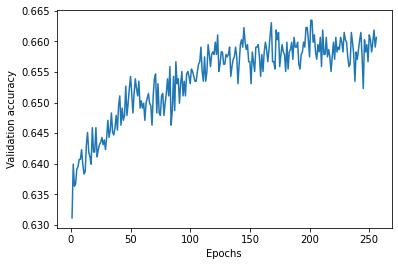

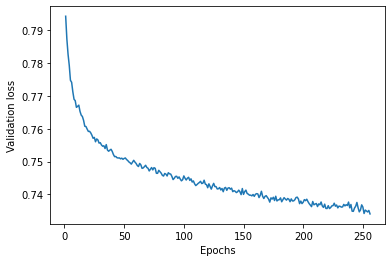

20/20 [==============================] - 0s 2ms/step - loss: 0.7422 - accuracy: 0.6699


[0.7422292232513428, 0.6698564887046814]

In [70]:
epochs=256

models["mlp_v28"] = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_v28"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v28"] = k_fold_validation(models["mlp_v28"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v28"], epochs=epochs)
plot_avg_loss(histories["mlp_v28"], epochs=epochs)

scores["mlp_v28"] = models["mlp_v28"].evaluate(X_test, y_test)
scores["mlp_v28"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


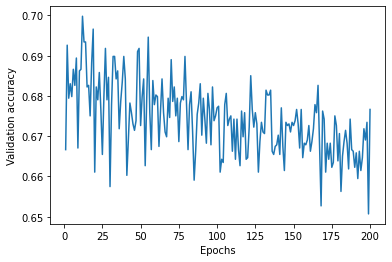

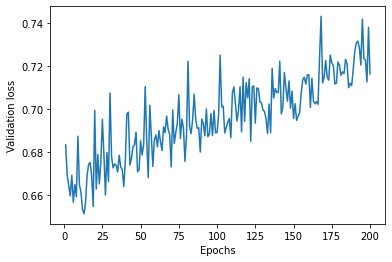

20/20 [==============================] - 0s 3ms/step - loss: 1.0873 - accuracy: 0.6188


[1.0873054265975952, 0.6188197731971741]

In [22]:
epochs=200

models["mlp_v23"] = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v23"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v23"] = k_fold_validation(models["mlp_v23"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v23"], epochs=epochs)
plot_avg_loss(histories["mlp_v23"], epochs=epochs)

scores["mlp_v23"] = models["mlp_v23"].evaluate(X_test, y_test)
scores["mlp_v23"]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


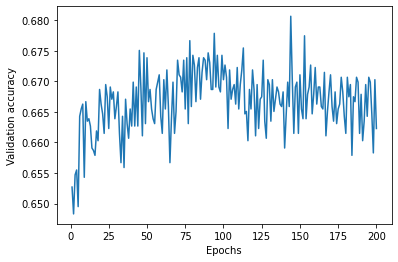

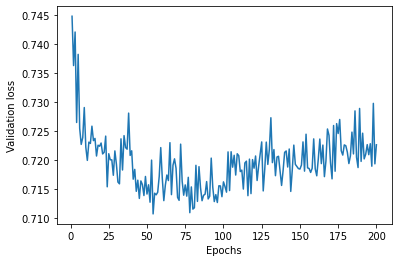

20/20 [==============================] - 0s 1ms/step - loss: 0.7669 - accuracy: 0.6411


[0.7669411897659302, 0.6411483287811279]

In [24]:
epochs=200

models["mlp_v30"] = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_v30"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v30"] = k_fold_validation(models["mlp_v30"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v30"], epochs=epochs)
plot_avg_loss(histories["mlp_v30"], epochs=epochs)

scores["mlp_v30"] = models["mlp_v30"].evaluate(X_test, y_test)
scores["mlp_v30"]

Processing fold #0
Accuracy Training: 0.6561876535415649 / Validation: 0.658682644367218
Loss Training: 0.7475208640098572 / Validation: 0.7120482921600342
Processing fold #1
Accuracy Training: 0.6671656966209412 / Validation: 0.6626746654510498
Loss Training: 0.7201303839683533 / Validation: 0.7362633347511292
Processing fold #2
Accuracy Training: 0.6691616773605347 / Validation: 0.6786426901817322
Loss Training: 0.7097474932670593 / Validation: 0.7372546792030334
Processing fold #3
Accuracy Training: 0.6686626672744751 / Validation: 0.6666666865348816
Loss Training: 0.7332379221916199 / Validation: 0.6912381052970886
Processing fold #4
Accuracy Training: 0.673652708530426 / Validation: 0.6926147937774658
Loss Training: 0.7102013826370239 / Validation: 0.7026822566986084


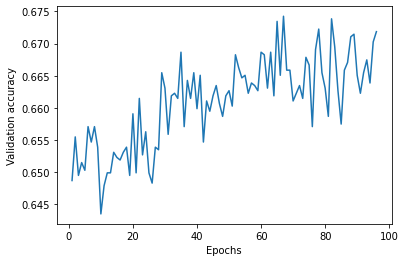

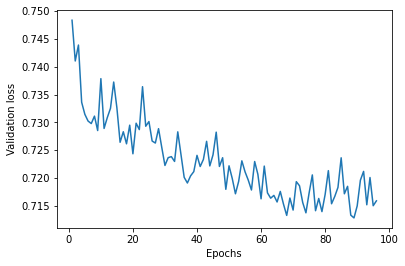

20/20 [==============================] - 0s 1ms/step - loss: 0.7445 - accuracy: 0.6746


[0.7444759011268616, 0.6746411323547363]

In [34]:
epochs=96

models["mlp_v31"] = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_v31"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v31"] = k_fold_validation(models["mlp_v31"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=256,
                                             k=5)

plot_avg_acc(histories["mlp_v31"], epochs=epochs)
plot_avg_loss(histories["mlp_v31"], epochs=epochs)

scores["mlp_v31"] = models["mlp_v31"].evaluate(X_test, y_test)
scores["mlp_v31"]

Processing fold #0
Accuracy Training: 0.6546906232833862 / Validation: 0.652694582939148
Loss Training: 0.7500834465026855 / Validation: 0.7104482650756836
Processing fold #1
Accuracy Training: 0.6711576581001282 / Validation: 0.6546906232833862
Loss Training: 0.7307878732681274 / Validation: 0.7333544492721558
Processing fold #2
Accuracy Training: 0.6651696562767029 / Validation: 0.6347305178642273
Loss Training: 0.7150051593780518 / Validation: 0.7337989807128906
Processing fold #3
Accuracy Training: 0.6816367506980896 / Validation: 0.6407185792922974
Loss Training: 0.720733106136322 / Validation: 0.7052114605903625
Processing fold #4
Accuracy Training: 0.6761476993560791 / Validation: 0.6946107745170593
Loss Training: 0.721598207950592 / Validation: 0.7026334404945374


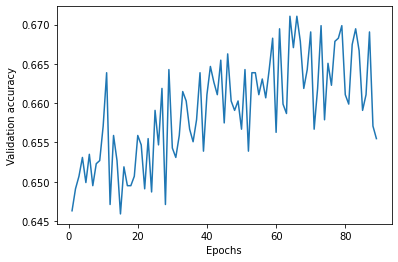

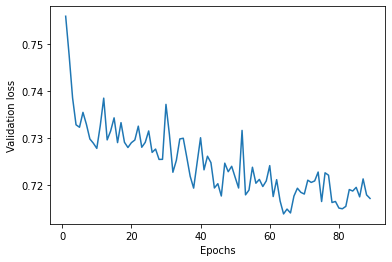

20/20 [==============================] - 0s 1ms/step - loss: 0.7407 - accuracy: 0.6730


[0.7406545281410217, 0.6730462312698364]

In [36]:
epochs=89

models["mlp_v32"] = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_v32"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v32"] = k_fold_validation(models["mlp_v32"],
                                         X_train, y_train, 
                                         epochs=epochs,
                                         batch_size=256,
                                         k=5)

plot_avg_acc(histories["mlp_v32"], epochs=epochs)
plot_avg_loss(histories["mlp_v32"], epochs=epochs)

scores["mlp_v32"] = models["mlp_v32"].evaluate(X_test, y_test)
scores["mlp_v32"]

Processing fold #0
Accuracy Training: 0.6372255682945251 / Validation: 0.6606786251068115
Loss Training: 0.762302815914154 / Validation: 0.7102605104446411
Processing fold #1
Accuracy Training: 0.6791417002677917 / Validation: 0.652694582939148
Loss Training: 0.7373222708702087 / Validation: 0.7453209757804871
Processing fold #2
Accuracy Training: 0.666167676448822 / Validation: 0.6566866040229797
Loss Training: 0.729819118976593 / Validation: 0.732794463634491
Processing fold #3
Accuracy Training: 0.6741517186164856 / Validation: 0.6626746654510498
Loss Training: 0.732301652431488 / Validation: 0.6912330389022827
Processing fold #4
Accuracy Training: 0.6741517186164856 / Validation: 0.682634711265564
Loss Training: 0.7199094295501709 / Validation: 0.7000934481620789


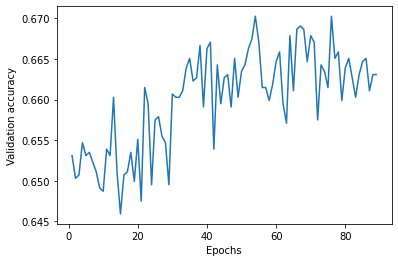

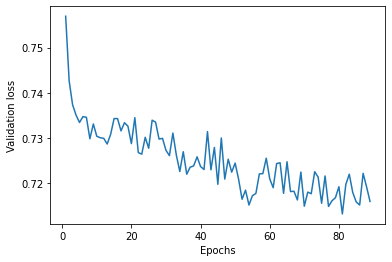

20/20 [==============================] - 0s 1ms/step - loss: 0.7357 - accuracy: 0.6651


[0.7357193827629089, 0.6650717854499817]

In [38]:
epochs=89

models["mlp_v33"] = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_v33"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v33"] = k_fold_validation(models["mlp_v33"],
                                         X_train, y_train, 
                                         epochs=epochs,
                                         batch_size=256,
                                         k=5)

plot_avg_acc(histories["mlp_v33"], epochs=epochs)
plot_avg_loss(histories["mlp_v33"], epochs=epochs)

scores["mlp_v33"] = models["mlp_v33"].evaluate(X_test, y_test)
scores["mlp_v33"]

Processing fold #0
Accuracy Training: 0.6546906232833862 / Validation: 0.6387225389480591
Loss Training: 0.7425854206085205 / Validation: 0.7365719676017761
Processing fold #1
Accuracy Training: 0.667664647102356 / Validation: 0.6566866040229797
Loss Training: 0.7287808656692505 / Validation: 0.7454725503921509
Processing fold #2
Accuracy Training: 0.673652708530426 / Validation: 0.658682644367218
Loss Training: 0.7232155203819275 / Validation: 0.7407864928245544
Processing fold #3
Accuracy Training: 0.6656686663627625 / Validation: 0.6726546883583069
Loss Training: 0.7319204211235046 / Validation: 0.6944769024848938
Processing fold #4
Accuracy Training: 0.6631736755371094 / Validation: 0.6926147937774658
Loss Training: 0.7294276356697083 / Validation: 0.7002381682395935


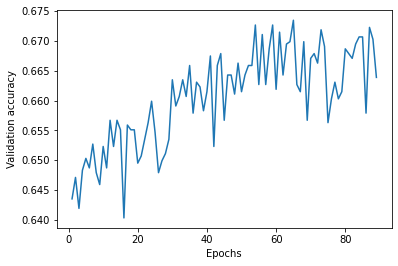

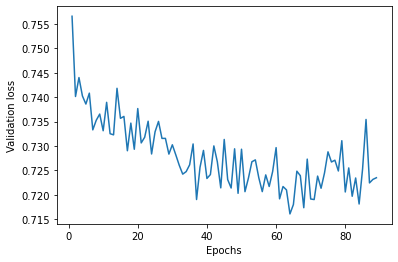

20/20 [==============================] - 0s 1ms/step - loss: 0.7385 - accuracy: 0.6571


[0.7385263442993164, 0.6570972800254822]

In [39]:
epochs=89

models["mlp_v34"] = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_v34"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v34"] = k_fold_validation(models["mlp_v34"],
                                         X_train, y_train, 
                                         epochs=epochs,
                                         batch_size=128,
                                         k=5)

plot_avg_acc(histories["mlp_v34"], epochs=epochs)
plot_avg_loss(histories["mlp_v34"], epochs=epochs)

scores["mlp_v34"] = models["mlp_v34"].evaluate(X_test, y_test)
scores["mlp_v34"]

Processing fold #0
Accuracy Training: 0.6561876535415649 / Validation: 0.6706587076187134
Loss Training: 0.7519770860671997 / Validation: 0.7132469415664673
Processing fold #1
Accuracy Training: 0.6596806645393372 / Validation: 0.6506986021995544
Loss Training: 0.7275125980377197 / Validation: 0.7357236742973328
Processing fold #2
Accuracy Training: 0.6711576581001282 / Validation: 0.6706587076187134
Loss Training: 0.7414594888687134 / Validation: 0.7425537109375
Processing fold #3
Accuracy Training: 0.660179615020752 / Validation: 0.6487026214599609
Loss Training: 0.731189489364624 / Validation: 0.6995140910148621
Processing fold #4
Accuracy Training: 0.6636726260185242 / Validation: 0.6966068148612976
Loss Training: 0.7348911166191101 / Validation: 0.7054527997970581


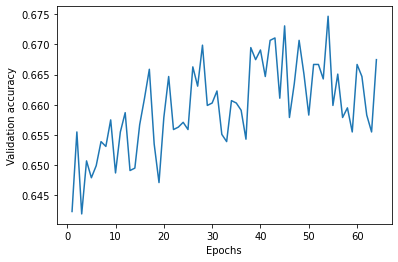

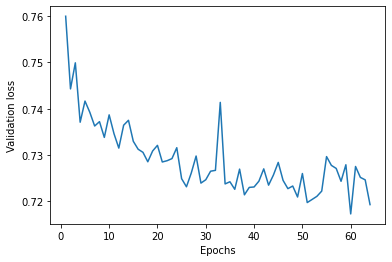

20/20 [==============================] - 0s 1ms/step - loss: 0.7373 - accuracy: 0.6667


[0.7373000979423523, 0.6666666865348816]

In [40]:
epochs=64

models["mlp_v35"] = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_v35"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v35"] = k_fold_validation(models["mlp_v35"],
                                         X_train, y_train, 
                                         epochs=epochs,
                                         batch_size=128,
                                         k=5)

plot_avg_acc(histories["mlp_v35"], epochs=epochs)
plot_avg_loss(histories["mlp_v35"], epochs=epochs)

scores["mlp_v35"] = models["mlp_v35"].evaluate(X_test, y_test)
scores["mlp_v35"]

Processing fold #0
Accuracy Training: 0.6631736755371094 / Validation: 0.682634711265564
Loss Training: 0.7598037123680115 / Validation: 0.7174259424209595
Processing fold #1
Accuracy Training: 0.6671656966209412 / Validation: 0.652694582939148
Loss Training: 0.7274761199951172 / Validation: 0.7360233068466187
Processing fold #2
Accuracy Training: 0.6616766452789307 / Validation: 0.6686626672744751
Loss Training: 0.721648633480072 / Validation: 0.7515588998794556
Processing fold #3
Accuracy Training: 0.6691616773605347 / Validation: 0.6646706461906433
Loss Training: 0.736261785030365 / Validation: 0.6938005089759827
Processing fold #4
Accuracy Training: 0.6656686663627625 / Validation: 0.6726546883583069
Loss Training: 0.729591965675354 / Validation: 0.7181218862533569


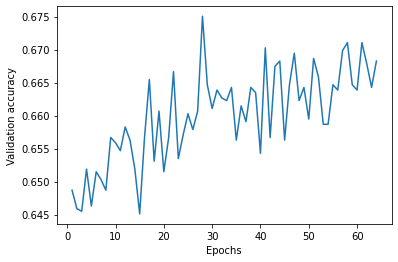

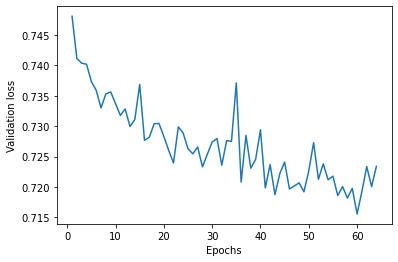

20/20 [==============================] - 0s 1ms/step - loss: 0.7430 - accuracy: 0.6603


[0.7429513931274414, 0.660287082195282]

In [41]:
epochs=64

models["mlp_v36"] = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_v36"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v36"] = k_fold_validation(models["mlp_v36"],
                                         X_train, y_train, 
                                         epochs=epochs,
                                         batch_size=128,
                                         k=5)

plot_avg_acc(histories["mlp_v36"], epochs=epochs)
plot_avg_loss(histories["mlp_v36"], epochs=epochs)

scores["mlp_v36"] = models["mlp_v36"].evaluate(X_test, y_test)
scores["mlp_v36"]

Processing fold #0
Accuracy Training: 0.6606786251068115 / Validation: 0.6546906232833862
Loss Training: 0.7634544372558594 / Validation: 0.7118796110153198
Processing fold #1
Accuracy Training: 0.6696606874465942 / Validation: 0.6447106003761292
Loss Training: 0.7289614677429199 / Validation: 0.7411624789237976
Processing fold #2
Accuracy Training: 0.6646706461906433 / Validation: 0.6746506690979004
Loss Training: 0.7218471765518188 / Validation: 0.7339830994606018
Processing fold #3
Accuracy Training: 0.6651696562767029 / Validation: 0.6686626672744751
Loss Training: 0.7292443513870239 / Validation: 0.7075575590133667
Processing fold #4
Accuracy Training: 0.6691616773605347 / Validation: 0.688622772693634
Loss Training: 0.7258036732673645 / Validation: 0.7025970220565796


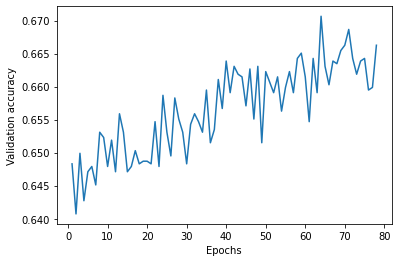

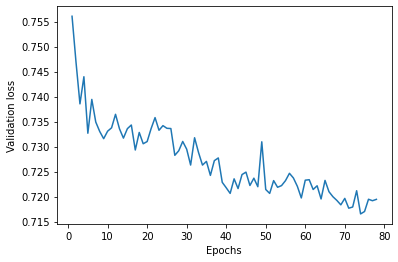

20/20 [==============================] - 0s 962us/step - loss: 0.7359 - accuracy: 0.6715


[0.7359369993209839, 0.6714513301849365]

In [43]:
epochs=78

models["mlp_v37"] = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_v37"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v37"] = k_fold_validation(models["mlp_v37"],
                                         X_train, y_train, 
                                         epochs=epochs,
                                         batch_size=256,
                                         k=5)

plot_avg_acc(histories["mlp_v37"], epochs=epochs)
plot_avg_loss(histories["mlp_v37"], epochs=epochs)

scores["mlp_v37"] = models["mlp_v37"].evaluate(X_test, y_test)
scores["mlp_v37"]

In [ ]:
epochs=200

models["mlp_v24"] = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(3, activation="softmax")
])
models["mlp_v24"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_v24"] = k_fold_validation(models["mlp_v24"],
                                             X_train, y_train, 
                                             epochs=epochs,
                                             batch_size=128,
                                             k=5)

plot_avg_acc(histories["mlp_v24"], epochs=epochs)
plot_avg_loss(histories["mlp_v24"], epochs=epochs)

scores["mlp_v24"] = models["mlp_v24"].evaluate(X_test, y_test)
scores["mlp_v24"]

## Treinando os modelos finais


In [50]:
epochs=200

models["mlp_1"] = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_1"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

models["mlp_1"].fit(X_train, y_train, 
                    epochs=epochs,
                    batch_size=128)

scores["mlp_1"] = models["mlp_1"].evaluate(X_test, y_test)
scores["mlp_1"]

Epoch 1/200
20/20 [==============================] - 1s 2ms/step - loss: 1.1575 - accuracy: 0.3717
Epoch 2/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0855 - accuracy: 0.4267
Epoch 3/200
20/20 [==============================] - 0s 3ms/step - loss: 1.0808 - accuracy: 0.4259
Epoch 4/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0505 - accuracy: 0.4507
Epoch 5/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0319 - accuracy: 0.4635
Epoch 6/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0274 - accuracy: 0.4527
Epoch 7/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0127 - accuracy: 0.4762
Epoch 8/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0009 - accuracy: 0.4866
Epoch 9/200
20/20 [==============================] - 0s 2ms/step - loss: 0.9911 - accuracy: 0.4786
Epoch 10/200
20/20 [==============================] - 0s 2ms/step - loss: 0.9839 - accuracy: 0.4958
Epoch 11/

[0.7541401982307434, 0.660287082195282]

In [53]:
epochs=100

models["mlp_2"] = keras.Sequential([
    layers.Dense(48, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(48, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_2"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

models["mlp_2"].fit(X_train, y_train, 
                    epochs=epochs,
                    batch_size=128)

scores["mlp_2"] = models["mlp_2"].evaluate(X_test, y_test)
scores["mlp_2"]

Epoch 1/100
20/20 [==============================] - 1s 2ms/step - loss: 1.0900 - accuracy: 0.4088
Epoch 2/100
20/20 [==============================] - 0s 2ms/step - loss: 1.0090 - accuracy: 0.4930
Epoch 3/100
20/20 [==============================] - 0s 2ms/step - loss: 0.9807 - accuracy: 0.5170
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 0.9537 - accuracy: 0.5277
Epoch 5/100
20/20 [==============================] - 0s 2ms/step - loss: 0.9336 - accuracy: 0.5265
Epoch 6/100
20/20 [==============================] - 0s 2ms/step - loss: 0.9327 - accuracy: 0.5273
Epoch 7/100
20/20 [==============================] - 0s 2ms/step - loss: 0.9144 - accuracy: 0.5293
Epoch 8/100
20/20 [==============================] - 0s 2ms/step - loss: 0.9032 - accuracy: 0.5481
Epoch 9/100
20/20 [==============================] - 0s 2ms/step - loss: 0.9009 - accuracy: 0.5401
Epoch 10/100
20/20 [==============================] - 0s 2ms/step - loss: 0.8888 - accuracy: 0.5477
Epoch 11/

[0.735767662525177, 0.6730462312698364]

In [54]:
epochs=200

models["mlp_3"] = keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_3"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

models["mlp_3"].fit(X_train, y_train, 
                    epochs=epochs,
                    batch_size=128)

scores["mlp_3"] = models["mlp_3"].evaluate(X_test, y_test)
scores["mlp_3"]

Epoch 1/200
20/20 [==============================] - 1s 2ms/step - loss: 1.1423 - accuracy: 0.3194
Epoch 2/200
20/20 [==============================] - 0s 2ms/step - loss: 1.1072 - accuracy: 0.3465
Epoch 3/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0995 - accuracy: 0.3569
Epoch 4/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0894 - accuracy: 0.3756
Epoch 5/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0789 - accuracy: 0.3968
Epoch 6/200
20/20 [==============================] - 0s 3ms/step - loss: 1.0763 - accuracy: 0.4052
Epoch 7/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0631 - accuracy: 0.4295
Epoch 8/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0480 - accuracy: 0.4371
Epoch 9/200
20/20 [==============================] - 0s 3ms/step - loss: 1.0373 - accuracy: 0.4723
Epoch 10/200
20/20 [==============================] - 0s 2ms/step - loss: 1.0286 - accuracy: 0.4778
Epoch 11/

[0.7475124597549438, 0.6634768843650818]

In [71]:
epochs=171

models["mlp_4"] = keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_4"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

models["mlp_4"].fit(X_train, y_train, 
                    epochs=epochs,
                    batch_size=128)

scores["mlp_4"] = models["mlp_4"].evaluate(X_test, y_test)
scores["mlp_4"]

Epoch 1/171
20/20 [==============================] - 1s 2ms/step - loss: 1.0158 - accuracy: 0.5034
Epoch 2/171
20/20 [==============================] - 0s 3ms/step - loss: 0.9440 - accuracy: 0.5301
Epoch 3/171
20/20 [==============================] - 0s 3ms/step - loss: 0.9047 - accuracy: 0.5405
Epoch 4/171
20/20 [==============================] - 0s 3ms/step - loss: 0.8827 - accuracy: 0.5481
Epoch 5/171
20/20 [==============================] - 0s 2ms/step - loss: 0.8706 - accuracy: 0.5581
Epoch 6/171
20/20 [==============================] - 0s 2ms/step - loss: 0.8644 - accuracy: 0.5585
Epoch 7/171
20/20 [==============================] - 0s 2ms/step - loss: 0.8649 - accuracy: 0.5593
Epoch 8/171
20/20 [==============================] - 0s 2ms/step - loss: 0.8568 - accuracy: 0.5561
Epoch 9/171
20/20 [==============================] - 0s 2ms/step - loss: 0.8503 - accuracy: 0.5653
Epoch 10/171
20/20 [==============================] - 0s 2ms/step - loss: 0.8418 - accuracy: 0.5752
Epoch 11/

[0.739739716053009, 0.660287082195282]

In [79]:
epochs=100

models["mlp_4"] = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_4"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

models["mlp_4"].fit(X_train, y_train, 
                    epochs=epochs,
                    batch_size=64)

scores["mlp_4"] = models["mlp_4"].evaluate(X_test, y_test)
scores["mlp_4"]

Epoch 1/100
40/40 [==============================] - 1s 2ms/step - loss: 1.0526 - accuracy: 0.4515
Epoch 2/100
40/40 [==============================] - 0s 2ms/step - loss: 0.9537 - accuracy: 0.5238
Epoch 3/100
40/40 [==============================] - 0s 2ms/step - loss: 0.9227 - accuracy: 0.5365
Epoch 4/100
40/40 [==============================] - 0s 2ms/step - loss: 0.9041 - accuracy: 0.5389
Epoch 5/100
40/40 [==============================] - 0s 3ms/step - loss: 0.8883 - accuracy: 0.5477
Epoch 6/100
40/40 [==============================] - 0s 3ms/step - loss: 0.8848 - accuracy: 0.5433
Epoch 7/100
40/40 [==============================] - 0s 2ms/step - loss: 0.8683 - accuracy: 0.5561
Epoch 8/100
40/40 [==============================] - 0s 2ms/step - loss: 0.8542 - accuracy: 0.5689
Epoch 9/100
40/40 [==============================] - 0s 2ms/step - loss: 0.8565 - accuracy: 0.5613
Epoch 10/100
40/40 [==============================] - 0s 2ms/step - loss: 0.8501 - accuracy: 0.5772
Epoch 11/

[0.7343205809593201, 0.6746411323547363]

In [93]:
epochs=100

models["mlp_p1"] = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_p1"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

models["mlp_p1"].fit(np.concatenate([X_train, X_test]),
                    np.concatenate([y_train, y_test]), 
                    epochs=epochs,
                    batch_size=64)

Epoch 1/100
49/49 [==============================] - 1s 4ms/step - loss: 1.0129 - accuracy: 0.4751
Epoch 2/100
49/49 [==============================] - 0s 5ms/step - loss: 0.9283 - accuracy: 0.5354
Epoch 3/100
49/49 [==============================] - 0s 5ms/step - loss: 0.8913 - accuracy: 0.5428
Epoch 4/100
49/49 [==============================] - 0s 6ms/step - loss: 0.8769 - accuracy: 0.5504
Epoch 5/100
49/49 [==============================] - 0s 4ms/step - loss: 0.8625 - accuracy: 0.5517
Epoch 6/100
49/49 [==============================] - 0s 6ms/step - loss: 0.8583 - accuracy: 0.5680
Epoch 7/100
49/49 [==============================] - 0s 2ms/step - loss: 0.8514 - accuracy: 0.5693
Epoch 8/100
49/49 [==============================] - 0s 2ms/step - loss: 0.8384 - accuracy: 0.5709
Epoch 9/100
49/49 [==============================] - 0s 2ms/step - loss: 0.8433 - accuracy: 0.5817
Epoch 10/100
49/49 [==============================] - 0s 2ms/step - loss: 0.8383 - accuracy: 0.5916
Epoch 11/

In [35]:
epochs=96

models["mlp_p2"] = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_p2"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

models["mlp_p2"].fit(np.concatenate([X_train, X_test]),
                     np.concatenate([y_train, y_test]),
                     epochs=epochs,
                     batch_size=64)

Epoch 1/96
49/49 [==============================] - 1s 2ms/step - loss: 0.9951 - accuracy: 0.4875
Epoch 2/96
49/49 [==============================] - 0s 2ms/step - loss: 0.9044 - accuracy: 0.5402
Epoch 3/96
49/49 [==============================] - 0s 2ms/step - loss: 0.8920 - accuracy: 0.5514
Epoch 4/96
49/49 [==============================] - 0s 2ms/step - loss: 0.8697 - accuracy: 0.5616
Epoch 5/96
49/49 [==============================] - 0s 2ms/step - loss: 0.8715 - accuracy: 0.5623
Epoch 6/96
49/49 [==============================] - 0s 2ms/step - loss: 0.8634 - accuracy: 0.5623
Epoch 7/96
49/49 [==============================] - 0s 2ms/step - loss: 0.8628 - accuracy: 0.5741
Epoch 8/96
49/49 [==============================] - 0s 2ms/step - loss: 0.8519 - accuracy: 0.5712
Epoch 9/96
49/49 [==============================] - 0s 2ms/step - loss: 0.8532 - accuracy: 0.5741
Epoch 10/96
49/49 [==============================] - 0s 2ms/step - loss: 0.8453 - accuracy: 0.5795
Epoch 11/96
49/49 [

In [47]:
epochs=78

models["mlp_p3"] = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_p3"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

models["mlp_p3"].fit(np.concatenate([X_train, X_test]),
                     np.concatenate([y_train, y_test]),
                     epochs=epochs,
                     batch_size=256)

Epoch 1/78
13/13 [==============================] - 1s 4ms/step - loss: 1.0440 - accuracy: 0.4489
Epoch 2/78
13/13 [==============================] - 0s 4ms/step - loss: 0.9593 - accuracy: 0.5281
Epoch 3/78
13/13 [==============================] - 0s 3ms/step - loss: 0.9292 - accuracy: 0.5358
Epoch 4/78
13/13 [==============================] - 0s 3ms/step - loss: 0.8988 - accuracy: 0.5399
Epoch 5/78
13/13 [==============================] - 0s 4ms/step - loss: 0.8959 - accuracy: 0.5450
Epoch 6/78
13/13 [==============================] - 0s 3ms/step - loss: 0.8863 - accuracy: 0.5575
Epoch 7/78
13/13 [==============================] - 0s 3ms/step - loss: 0.8760 - accuracy: 0.5489
Epoch 8/78
13/13 [==============================] - 0s 3ms/step - loss: 0.8711 - accuracy: 0.5600
Epoch 9/78
13/13 [==============================] - 0s 3ms/step - loss: 0.8810 - accuracy: 0.5543
Epoch 10/78
13/13 [==============================] - 0s 3ms/step - loss: 0.8630 - accuracy: 0.5661
Epoch 11/78
13/13 [

Processing fold #0
Accuracy Training: 0.6560255289077759 / Validation: 0.6805111765861511
Loss Training: 0.760697066783905 / Validation: 0.6980459690093994
Processing fold #1
Accuracy Training: 0.6588188409805298 / Validation: 0.6565495133399963
Loss Training: 0.7257346510887146 / Validation: 0.7864884734153748
Processing fold #2
Accuracy Training: 0.6691939234733582 / Validation: 0.6613418459892273
Loss Training: 0.7394562363624573 / Validation: 0.7031829357147217
Processing fold #3
Accuracy Training: 0.6727853417396545 / Validation: 0.6741213798522949
Loss Training: 0.7352303862571716 / Validation: 0.6994221210479736
Processing fold #4
Accuracy Training: 0.6560255289077759 / Validation: 0.6517571806907654
Loss Training: 0.7244414687156677 / Validation: 0.7288278937339783


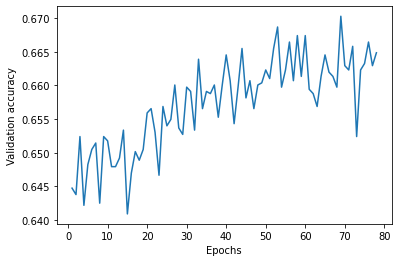

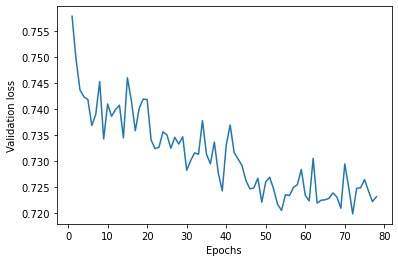

In [44]:
epochs=78

models["mlp_large"] = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_large"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_large"] = k_fold_validation(models["mlp_large"],
                                           np.concatenate([X_train, X_test]),
                                           np.concatenate([y_train, y_test]), 
                                           epochs=epochs,
                                           batch_size=256,
                                           k=5)

plot_avg_acc(histories["mlp_large"], epochs=epochs)
plot_avg_loss(histories["mlp_large"], epochs=epochs)

Processing fold #0
Accuracy Training: 0.6436552405357361 / Validation: 0.6709265112876892
Loss Training: 0.7741175889968872 / Validation: 0.7030683755874634
Processing fold #1
Accuracy Training: 0.6580207347869873 / Validation: 0.6501597166061401
Loss Training: 0.7254197597503662 / Validation: 0.7956289052963257
Processing fold #2
Accuracy Training: 0.6652035117149353 / Validation: 0.664536714553833
Loss Training: 0.7388452887535095 / Validation: 0.698441743850708
Processing fold #3
Accuracy Training: 0.653232216835022 / Validation: 0.6884983777999878
Loss Training: 0.7448555827140808 / Validation: 0.706031322479248
Processing fold #4
Accuracy Training: 0.6723862886428833 / Validation: 0.6661341786384583
Loss Training: 0.7225943803787231 / Validation: 0.7198821902275085


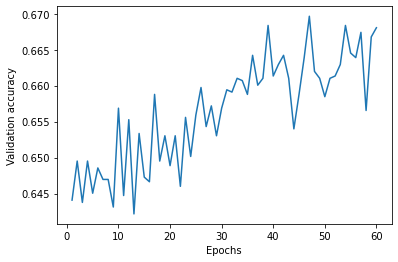

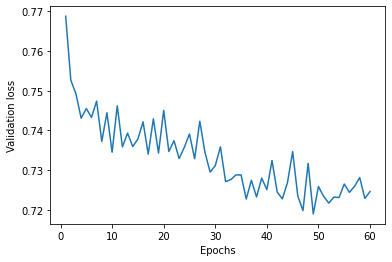

In [51]:
epochs=60

models["mlp_large2"] = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_large2"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_large2"] = k_fold_validation(models["mlp_large2"],
                                           np.concatenate([X_train, X_test]),
                                           np.concatenate([y_train, y_test]), 
                                           epochs=epochs,
                                           batch_size=256,
                                           k=5)

plot_avg_acc(histories["mlp_large2"], epochs=epochs)
plot_avg_loss(histories["mlp_large2"], epochs=epochs)

In [53]:
epochs=60

models["mlp_p4"] = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_p4"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

models["mlp_p4"].fit(np.concatenate([X_train, X_test]),
                     np.concatenate([y_train, y_test]),
                     epochs=epochs,
                     batch_size=256)

Epoch 1/60
13/13 [==============================] - 1s 3ms/step - loss: 1.0333 - accuracy: 0.4591
Epoch 2/60
13/13 [==============================] - 0s 3ms/step - loss: 0.9485 - accuracy: 0.5144
Epoch 3/60
13/13 [==============================] - 0s 3ms/step - loss: 0.9186 - accuracy: 0.5348
Epoch 4/60
13/13 [==============================] - 0s 3ms/step - loss: 0.8981 - accuracy: 0.5380
Epoch 5/60
13/13 [==============================] - 0s 3ms/step - loss: 0.8764 - accuracy: 0.5607
Epoch 6/60
13/13 [==============================] - 0s 3ms/step - loss: 0.8845 - accuracy: 0.5492
Epoch 7/60
13/13 [==============================] - 0s 3ms/step - loss: 0.8677 - accuracy: 0.5587
Epoch 8/60
13/13 [==============================] - 0s 3ms/step - loss: 0.8564 - accuracy: 0.5568
Epoch 9/60
13/13 [==============================] - 0s 3ms/step - loss: 0.8586 - accuracy: 0.5546
Epoch 10/60
13/13 [==============================] - 0s 4ms/step - loss: 0.8553 - accuracy: 0.5709
Epoch 11/60
13/13 [

In [ ]:
epochs=65

models["mlp_p4"] = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_p4"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

models["mlp_p4"].fit(np.concatenate([X_train, X_test]),
                     np.concatenate([y_train, y_test]),
                     epochs=epochs,
                     batch_size=256)

## Dando um passo atrás

In [114]:
features_num = X_train.select_dtypes(include=np.number).columns[:-3]
feature_cols_post = ["length", "diameter", "height", "whole_weight",
                     "shucked_weight", "viscera_weight", "shell_weight",
                     "sex_F", "sex_I", "sex_M"]
ct = ColumnTransformer([
    ("num_scaler", StandardScaler(), features_num)
], remainder="passthrough")

ct.fit(X_train)
X_train_std = pd.DataFrame(ct.transform(X_train),
                           columns=feature_cols_post)
X_train_std

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_F,sex_I,sex_M
0,0.442268,0.643305,0.041113,0.034364,-0.035334,-0.050020,0.029837,0.0,0.0,1.0
1,-0.052709,0.192065,0.041113,-0.111043,-0.235177,-0.059092,0.137539,1.0,0.0,0.0
2,-0.588933,-0.710416,-0.593053,-0.868582,-0.724678,-0.979974,-0.903578,0.0,1.0,0.0
3,-0.753925,-0.660278,-0.719887,-0.927558,-0.886349,-0.848419,-0.939478,0.0,1.0,0.0
4,0.854748,0.893995,0.675280,0.897653,0.676464,1.260989,1.106854,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2500,-0.423941,-0.509865,1.055780,-0.692670,-0.677525,-0.671501,-0.612783,0.0,1.0,0.0
2501,0.813500,0.994270,1.182613,1.437591,1.498288,1.714626,0.819649,0.0,0.0,1.0
2502,-0.918917,-1.011243,-0.973553,-0.930608,-0.821232,-1.034410,-0.903578,1.0,0.0,0.0
2503,-0.712677,-0.810692,-0.466220,-0.856380,-0.785305,-1.070701,-0.885627,0.0,1.0,0.0


In [115]:
X_test_std = pd.DataFrame(ct.transform(X_test),
                           columns=feature_cols_post)
X_test_std

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_F,sex_I,sex_M
0,-0.918917,-0.810692,-0.466220,-0.907221,-0.890840,-0.889247,-0.795876,0.0,0.0,1.0
1,0.813500,0.793719,0.421613,0.760381,0.692182,0.834571,0.834009,1.0,0.0,0.0
2,1.885948,1.445511,1.436280,2.057857,2.127006,1.696480,1.465859,1.0,0.0,0.0
3,0.442268,0.292341,0.041113,0.050633,0.200435,0.108753,-0.099405,0.0,0.0,1.0
4,-1.290149,-1.412346,-0.085720,-1.218372,-1.128854,-1.197719,-1.258993,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
622,0.359772,0.342478,-0.085720,-0.106975,-0.116169,-0.367565,0.083688,0.0,1.0,0.0
623,0.566012,0.643305,0.167947,0.209259,0.440695,-0.054556,0.130358,0.0,0.0,1.0
624,-0.836421,-0.810692,-0.719887,-1.007888,-1.041283,-0.939147,-0.957429,0.0,1.0,0.0
625,0.112283,-0.058624,0.167947,-0.235096,-0.223950,-0.385710,-0.113765,0.0,1.0,0.0


Processing fold #0
Accuracy Training: 0.6596806645393372 / Validation: 0.6786426901817322
Loss Training: 0.7449648380279541 / Validation: 0.7006153464317322
Processing fold #1
Accuracy Training: 0.6851297616958618 / Validation: 0.658682644367218
Loss Training: 0.7025253772735596 / Validation: 0.7219106554985046
Processing fold #2
Accuracy Training: 0.6966068148612976 / Validation: 0.6646706461906433
Loss Training: 0.6714534759521484 / Validation: 0.7159794569015503
Processing fold #3
Accuracy Training: 0.6956087946891785 / Validation: 0.6686626672744751
Loss Training: 0.6806194186210632 / Validation: 0.6796186566352844
Processing fold #4
Accuracy Training: 0.6946107745170593 / Validation: 0.7045907974243164
Loss Training: 0.6703146696090698 / Validation: 0.6717100739479065


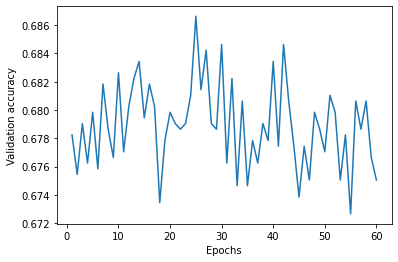

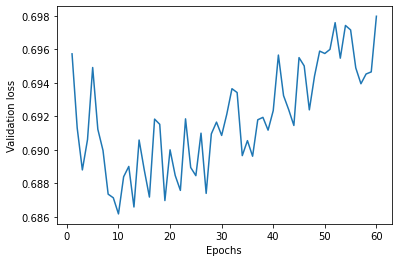

20/20 [==============================] - 0s 981us/step - loss: 0.7694 - accuracy: 0.6651


[0.7693989872932434, 0.6650717854499817]

In [116]:
epochs=60

models["mlp_large3"] = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])
models["mlp_large3"].compile(optimizer="rmsprop",
                         loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"])

histories["mlp_large3"] = k_fold_validation(models["mlp_large3"],
                                            X_train_std,
                                            y_train, 
                                            epochs=epochs,
                                            batch_size=256,
                                            k=5)

plot_avg_acc(histories["mlp_large3"], epochs=epochs)
plot_avg_loss(histories["mlp_large3"], epochs=epochs)

scores["mlp_large3"] = models["mlp_large3"].evaluate(X_test_std, y_test)
scores["mlp_large3"]

## Submetendo o modelo

Carregando a base de teste

In [88]:
data_app = pd.read_csv('https://raw.githubusercontent.com/aydanomachado/mlclass/master/03_Validation/abalone_app.csv')
data_app

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
0,M,0.600,0.480,0.175,1.2290,0.4125,0.2735,0.4150
1,F,0.545,0.385,0.150,1.1185,0.5425,0.2445,0.2845
2,F,0.645,0.520,0.180,1.2850,0.5775,0.3520,0.3170
3,M,0.640,0.510,0.170,1.3715,0.5670,0.3070,0.4090
4,F,0.655,0.540,0.215,1.5555,0.6950,0.2960,0.4440
...,...,...,...,...,...,...,...,...
1040,I,0.430,0.350,0.105,0.3660,0.1705,0.0855,0.1100
1041,F,0.475,0.360,0.125,0.4470,0.1695,0.0810,0.1400
1042,F,0.500,0.405,0.150,0.5965,0.2530,0.1260,0.1850
1043,I,0.380,0.275,0.095,0.2425,0.1060,0.0485,0.2100


Aplicando o one-hot encoding à variável sex

In [89]:
data_app = pd.get_dummies(data=data_app, columns=['sex'])
data_app

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_F,sex_I,sex_M
0,0.600,0.480,0.175,1.2290,0.4125,0.2735,0.4150,0,0,1
1,0.545,0.385,0.150,1.1185,0.5425,0.2445,0.2845,1,0,0
2,0.645,0.520,0.180,1.2850,0.5775,0.3520,0.3170,1,0,0
3,0.640,0.510,0.170,1.3715,0.5670,0.3070,0.4090,0,0,1
4,0.655,0.540,0.215,1.5555,0.6950,0.2960,0.4440,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1040,0.430,0.350,0.105,0.3660,0.1705,0.0855,0.1100,0,1,0
1041,0.475,0.360,0.125,0.4470,0.1695,0.0810,0.1400,1,0,0
1042,0.500,0.405,0.150,0.5965,0.2530,0.1260,0.1850,1,0,0
1043,0.380,0.275,0.095,0.2425,0.1060,0.0485,0.2100,0,1,0


In [102]:
data_app.isna().sum()

length            0
diameter          0
height            0
whole_weight      0
shucked_weight    0
viscera_weight    0
shell_weight      0
sex_F             0
sex_I             0
sex_M             0
dtype: int64

Gerando as previsões

In [114]:
y_pred = models["mlp_p1"].predict(data_app)
y_pred

array([[0.00147305, 0.07889049, 0.91963655],
       [0.18068847, 0.5740746 , 0.24523696],
       [0.08650257, 0.54879296, 0.3647045 ],
       ...,
       [0.11601897, 0.37583736, 0.5081437 ],
       [0.29783297, 0.37666723, 0.32549983],
       [0.06809769, 0.3888228 , 0.54307956]], dtype=float32)

In [115]:
y_pred = y_pred.argmax(axis=1) + 1
y_pred

array([3, 2, 2, ..., 3, 2, 3])

In [116]:
# Enviando previsões realizadas com o modelo para o servidor
URL = "https://aydanomachado.com/mlclass/03_Validation.php"

#TODO Substituir pela sua chave aqui
DEV_KEY = "720pster"

# json para ser enviado para o servidor
data = {'dev_key':DEV_KEY,
        'predictions':pd.Series(y_pred).to_json(orient='values')}

In [117]:
data

{'dev_key': '720pster',
 'predictions': '[3,2,2,3,3,1,1,2,3,3,3,3,3,3,1,3,2,1,3,3,2,2,1,2,3,2,3,3,3,3,3,2,1,3,2,2,2,3,3,2,2,3,3,3,3,3,3,3,3,1,2,3,3,3,2,3,3,1,3,2,3,3,3,3,2,1,3,3,3,1,2,3,2,2,1,1,2,2,1,1,3,3,2,2,2,3,2,2,2,3,3,2,3,2,2,2,3,3,3,1,2,1,1,3,2,1,1,3,2,3,3,3,3,3,1,3,3,2,2,2,2,1,2,3,2,3,2,1,1,3,2,1,3,2,2,3,2,3,2,2,3,3,1,3,1,2,1,2,1,3,3,1,1,2,2,3,3,3,1,2,2,2,3,1,3,1,3,3,1,2,3,2,2,2,2,2,2,2,2,1,1,1,2,2,1,3,2,3,1,3,2,2,2,3,3,2,2,3,3,1,2,2,1,2,2,1,2,1,3,3,1,3,3,2,3,3,1,1,3,1,3,1,1,2,1,3,2,2,3,3,1,1,3,2,3,2,3,1,1,3,2,3,2,3,3,3,3,2,2,1,3,3,3,2,1,3,1,3,2,3,3,1,2,3,2,2,3,3,2,1,3,1,3,3,1,2,2,3,2,1,2,1,1,2,2,3,3,1,3,2,3,3,2,2,3,2,1,2,1,2,1,2,1,2,3,3,2,3,2,2,3,2,3,3,2,2,3,1,1,3,3,2,2,2,3,3,1,2,1,3,3,3,1,1,3,1,2,1,2,3,2,3,3,2,2,2,1,1,1,1,2,3,2,2,3,3,3,3,1,3,3,1,2,3,3,2,1,2,2,3,1,1,3,2,3,2,2,1,1,2,1,2,2,3,3,1,2,1,2,2,1,1,1,3,2,1,2,1,1,2,2,2,2,3,2,3,1,3,1,3,2,2,3,1,3,2,2,3,1,1,2,3,3,3,3,2,3,2,1,3,3,1,2,3,2,2,3,2,3,3,2,2,3,2,2,3,1,1,2,3,3,1,3,3,3,3,1,1,1,1,3,3,2,2,3,3,3,3,2,3,2,2,3,3,1,1,3,2,3,

In [118]:
# Enviando requisição e salvando o objeto resposta
#r = requests.post(url = URL, data = data)

# Extraindo e imprimindo o texto da resposta
pastebin_url = r.text
print(" - Resposta do servidor:\n", r.text, "\n")

 - Resposta do servidor:
 {"status":"success","dev_key":"720pster","accuracy":0.6535885167464115,"old_accuracy":0.66028708133971} 

